# Neural Network from Scratch


Fully-connected neural network from scratch (NumPy): forward/backward pass, backprop, SGD. Trained on **Fashion MNIST** for image classification.


## Setup


In [ ]:
import gdown
!gdown 19WmxrqT3Zm8tJ037IvccuIMWvLAeyu1e --quiet
!gdown 1N1ayKanSayxwx9gvhpboUwi3rJuX2eo6 -O linclass.py --quiet


In [2]:
from typing import Optional,List
import abc
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, transform
import time
import utils
import seaborn as sns
from scipy import stats


/content/utils.py:259: SyntaxWarning: invalid escape sequence '\w'
  data['text'] = data['text'].str.replace('[^\w\s]', '', regex=True)


## Neural Networks

We model a network as a DAG: nodes = activations, edges = weights. Each **Module** implements `forward(x)` (sets `_input`, `_output`) and `backward(grad_output)` (sets `_grad_input`, parameter gradients). `train_mode()` / `eval_mode()` toggles behavior (e.g. Dropout). Parameters: `get_params()`, `set_params()`, `get_grad_params()`.


In [4]:

import linclass

class Module(abc.ABC):
    '''
    A module defines a sub-graph G' = (V, E) in the DAG G that represents a
    neural network. Therefore G' is a subset of G. An instantiation of a module
    thus represents a realization of a subgraph, comprising of a set of nodes and
    their connections.
    '''
    def __init__(self):
        # Train mode or eval mode
        self.train = True

        # Forward pass cache
        self._input = None
        self._output = None

        # Backward pass cache
        self._grad_output = None
        self._grad_input = None

    @abc.abstractmethod
    def forward(self, x: np.ndarray):
        '''
        Computes the forward pass z = f(x) where f is the function represented by
        the module, x is the input, and z is the output of the forward pass.

        Assigns to attributes self._input and self._output.

        Args:
            x: Data features. shape (m, in_dim) where m is the number of data
                points and in_dim is the number of input features.
        '''
        pass

    def _check_forward_attrs(self):
        '''Sanity check after a forward pass.'''
        assert self._input is not None
        assert self._output is not None

    @abc.abstractmethod
    def backward(self, grad_output: np.ndarray):
        '''
        Computes the gradient of loss w.r.t. cached input and trainable parameters.

        Assigns to attributes self._grad_output and self._grad_input.
        The gradients w.r.t. trainable parameters must also be cached so that
        they can be returned by self.get_grad_params().

        Args:
            grad_output: Gradient of loss w.r.t. output z of the module, dL/dz.
                shape (m, out_dim) where m is the number of data points and
                out_dim is the number of output features.
        '''
        pass

    def _check_backward_attrs(self):
        '''Sanity check after a backward pass.'''
        assert self._grad_output is not None
        assert self._grad_input is not None

    def get_params(self) -> Optional[np.ndarray]:
        '''
        Returns the trainable parameters of the module. If there are no trainable
        parameters, returns None.

        Returns:
            arr: (jagged) array of trainable parameters, where the entries are
                differently-sized numpy arrays themselves.
        '''
        return None

    def set_params(self, params: np.ndarray):
        '''
        Sets the trainable parameters to params. If there are no trainable parameters
        to set, raises a RuntimeError.

        Args:
            params: (jagged) array of trainable parameters, in the same order
                as obtained from self.get_params(). The identity operation is satisfied:
                ```
                x = self.get_params()
                self.set_params(x)
                x == self.get_params()
                ```
        '''
        raise RuntimeError('No trainable parameters to set!')

    def get_grad_params(self) -> Optional[np.ndarray]:
        '''
        Returns the gradients of the loss w.r.t. trainable parameters of the module.
        If there are no trainable parameters, returns None.

        Returns:
            arr: (jagged) array of gradients of trainable parameters,
                where the entries are differently-sized numpy arrays themselves.
        '''
        return None

    def train_mode(self):
        '''
        Switches on the training mode. Useful e.g. in Dropout, where the nodes must be
        dropped only during training, not evaluation.
        '''
        self.train = True

    def eval_mode(self):
        '''
        Switches on the evaluation mode. Useful e.g. in Dropout, where the nodes must be
        dropped only during training, not evaluation.
        '''
        self.train = False


### Sequential (feed-forward)

Stack of modules: forward chains layer outputs; backward iterates layers in reverse, passing `_grad_input` to the previous layer. Final gradients go in `_grad_input`.


In [5]:
class Sequential(Module):
    '''
    A sequence of modules, representing a DAG path.
    '''
    def __init__(self, layers: List[Module]):
        '''
        Args:
            layers: A list of modules to initialize the sequential network.
        '''
        super(Sequential, self).__init__()
        self.layers = layers

    def add(self, layer: Module):
        '''
        Adds the layer at the end of the sequential network.
        '''
        self.layers.append(layer)

    def forward(self, x: np.ndarray):
        '''
        Computes a forward pass sequentially on the network layers.
        '''
        self._input = x
        n_layers = len(self.layers)
        for i in range(n_layers):
            _output_prev = self._input if i == 0 else self.layers[i-1]._output
            self.layers[i].forward(_output_prev)
        self._output = self._input if n_layers == 0 else self.layers[-1]._output

        self._check_forward_attrs()

    def backward(self, grad_output: np.ndarray):
        '''
        Backpropagates the gradient w.r.t. output of the sequential network,
        computing gradients w.r.t. input and trainable parameters of the network.
        '''
        self._grad_output = grad_output
        grad = grad_output
        for layer in reversed(self.layers):
          layer.backward(grad)
          grad = layer._grad_input
        self._grad_input = grad
        self._check_backward_attrs()


    def get_params(self) -> Optional[np.ndarray]:
        params = []
        for layer in self.layers:
            p = layer.get_params()
            if p is not None:
                params.append(p)

        arr = np.empty(len(params), dtype=np.ndarray)
        arr[:] = params
        return arr

    def set_params(self, params: np.ndarray):
        # Since params has trainable parameters listed in the same order as
        # get_params() would have returned, follow the same iteration, and call
        # layer.set_params() on params[i] where i is the ith layer with any trainable
        # parameters
        i = 0
        for layer in self.layers:
            p = layer.get_params()
            if p is not None:
                layer.set_params(params[i])
                i += 1

    def get_grad_params(self) -> Optional[np.ndarray]:
        grad_params = []
        for layer in self.layers:
            g = layer.get_grad_params()
            if g is not None:
                grad_params.append(g)
        arr = np.empty(len(grad_params), dtype=np.ndarray)
        arr[:] = grad_params
        return arr

    def train_mode(self):
        # Switch on training in all layers
        super().train_mode()
        for layer in self.layers:
            layer.train_mode()

    def eval_mode(self):
        # Switch on eval in all layers
        super().eval_mode()
        for layer in self.layers:
            layer.eval_mode()


### Linear layer

$z = xW + b$. Backward: $dL/dx = (dL/dz) W^T$, $dL/dW = x^T (dL/dz)$, $dL/db = \sum dL/dz$. Weights initialized $\mathcal{N}(0, \sqrt{2/d_{in}})$.


In [7]:
class Linear(Module):
    '''
    Linear transformation on the inputs, z = xW + b.

    Corresponds to all nodes in the preceding layer connected to all nodes in the
    current layer.
    '''
    def __init__(self, in_dim: int, out_dim: int):
        '''
        Args:
            in_dim: Number of input dimensions (number of incoming connections
                in the network).
            out_dim: Number of output dimensions (number of outgoing connections
                in the network).
        '''
        super(Linear, self).__init__()

        # Initialize trainable parameters
        self.weight = np.random.normal(0, np.sqrt(2/in_dim), (in_dim, out_dim))
        self.bias =  np.zeros(out_dim)

        # Initialize gradients w.r.t. trainable parameters
        self._grad_weight = None
        self._grad_bias = None

    def forward(self, x: np.ndarray):
        '''
        Args:
            x: Data features. shape (m, in_dim)
        '''
        assert x.shape[1] == self.weight.shape[0]

        self._input = x
        self._output = x @ self.weight + self.bias
        self._check_forward_attrs()

    def backward(self, grad_output: np.ndarray) -> np.ndarray:
        '''
        Computes gradient w.r.t. trainable parameters and input and returns the gradient
        w.r.t. input.

        Important: gradients are accumulated for trainable parameters, i.e. added to the existing
        values.

        Args:
            grad_output: Gradient w.r.t. output dL/dz. shape (m, out_dim)

        Returns:
            grad_input: shape (m, in_dim)
        '''
        assert grad_output.shape[1] == self.weight.shape[1]
        self._grad_output = grad_output
        grad_w = self._input.T @ grad_output
        grad_b = np.sum(grad_output, axis=0)

        if self._grad_weight is None:
          self._grad_weight = grad_w
        else:
          self._grad_weight += grad_w

        if self._grad_bias is None:
          self._grad_bias = grad_b
        else:
          self._grad_bias += grad_b

        grad_input = grad_output @ self.weight.T
        self._grad_input = grad_input
        self._check_backward_attrs()
        return grad_input

    def _check_backward_attrs(self):
        super()._check_backward_attrs()
        assert self._grad_weight is not None
        assert self._grad_bias is not None

    def get_params(self) -> Optional[np.ndarray]:
        params = np.empty(2, dtype=np.ndarray)
        params[0] = self.weight
        params[1] = self.bias
        return params

    def set_params(self, params: np.ndarray):
        assert len(params) == 2
        self.weight = params[0]
        self.bias = params[1]

    def get_grad_params(self) -> Optional[np.ndarray]:
        grad_params = np.empty(2, dtype=np.ndarray)
        grad_params[0] = self._grad_weight
        grad_params[1] = self._grad_bias
        return grad_params


### ReLU

$z = \max(0, x)$. No parameters; backward: gradient passes through where $x > 0$.


In [8]:
class ReLU(Module):
    '''
    ReLU activation, not trainable. z = max(x, 0) for each input value x.
    '''
    def __init__(self):
        super(ReLU, self).__init__()

    def forward(self, x: np.ndarray):
        '''
        Args:
            x: Data features. shape (m, in_dim)
        '''
        self._input = x
        self._output = np.maximum(0, x)
        self._check_forward_attrs()

    def backward(self, grad_output: np.ndarray) -> np.ndarray:
        '''
        Since there are no trainable parameters, only the gradient w.r.t. input is computed.

        Args:
            grad_output: Gradient w.r.t. output dL/dz. Any shape
        '''
        assert grad_output.shape == self._input.shape
        self._grad_output = grad_output
        relu_mask = (self._input > 0).astype(self._input.dtype)
        self._grad_input = grad_output * relu_mask
        self._check_backward_attrs()


### Dropout

During training, zero out nodes with probability $p$; scale kept values by $1/(1-p)$. Off at eval (`eval_mode()`).


In [9]:
class Dropout(Module):
    '''
    A dropout layer.
    '''
    def __init__(self, p: float = 0.5):
        '''
        Args:
            p: (default 0.5) Probability of dropping each node (prob. of setting each value to 0).
                If p is 0, then no nodes are dropped, i.e. we get the identity layer.
        '''
        assert 0 <= p <= 1
        super(Dropout, self).__init__()
        self.p = p

    def forward(self, x: np.ndarray):
        self._input = x
        self._output = self._input
        if self.train and (not np.isclose(self.p, 0)):
            # In training mode and drop probability is positive

            # Create a mask to apply to the input using Bernoulli(1-p) RV
            self.mask = np.random.binomial(1, 1 - self.p, x.shape).astype(float)

            # Scale the mask so that the expected value of prediction during
            # testing is same as x, and not (1-p)x
            self.mask = self.mask / (1 - self.p)
            self._output = x * self.mask
        self._check_forward_attrs()

    def backward(self, grad_output: np.ndarray):
        self._grad_output = grad_output
        self._grad_input = self._grad_output
        if self.train and (not np.isclose(self.p, 0)):
            # In training mode and drop probability is positive, _grad_input is masked
            self._grad_input = grad_output * self.mask
        self._check_backward_attrs()


### MultiLogisticLoss (cross-entropy)

Softmax on logits $r$; loss = $-\frac{1}{m}\sum \log p_{y_i}$. Backward: $p - \mathbf{1}_y$ (scaled). Uses `utils.softmax`.


In [17]:
class Loss(abc.ABC):
    '''Defines a loss function.'''
    def __init__(self, k: int):
        '''
        Args:
            k: Number of labels.
        '''
        self.k = k
        self._input = None
        self._input_target = None
        self._output = None
        self._grad_input = None

    @abc.abstractmethod
    def forward(self, r: np.ndarray, y: np.ndarray):
        '''
        Computes the loss value using responses r and true labels y.

        Sets the attributes self._input, self._input_target, and self._output.

        Args:
            r: Responses of a classifier. shape (m, k) where m is the number of data
                points.
            y: True labels. shape (m). For all i, 0 <= y_i < k
        '''
        pass

    def _check_forward_attrs(self):
        assert self._input is not None
        assert self._input_target is not None
        assert self._output is not None

    @abc.abstractmethod
    def backward(self):
        '''
        Computes the gradient of the loss value w.r.t. cached responses.

        Sets the attribute self._grad_input.
        '''
        pass

    def _check_backward_attrs(self):
        assert self._grad_input is not None


class MultiLogisticLoss(Loss):
    def __init__(self, k: int):
        super(MultiLogisticLoss, self).__init__(k)

    def forward(self, r: np.ndarray, y: np.ndarray):
        '''
        Computes the multiclass logistic loss, using the softmax operation to
        convert responses r to normalized probabilities.
        '''
        assert r.shape[0] == y.shape[0]
        assert r.shape[1] == self.k
        self._input = r
        self._input_target = y
        self._output = -np.mean(np.log(utils.softmax(r)[np.arange(r.shape[0]), y]))
        self._check_forward_attrs()

    def backward(self):
        #utils.softmax(self._input)[np.arange(self._input.shape[0]), self._input_target] -= 1 Note to myself I forget modifies the array itself
        m = self._input.shape[0]
        soft = utils.softmax(self._input)
        soft[np.arange(m), self._input_target] -= 1
        self._grad_input = soft / self._input.shape[0]
        self._check_backward_attrs()


### Gradient checks

Numerical gradient vs backprop; relative error should be $\lesssim 10^{-8}$.


In [18]:
def test_log_grad():
    '''
    Tests MultiLogisticLoss Gradient implementation. The relative error should be small.
    '''
    print('Multi Logistic Loss Grad Test')
    loss = MultiLogisticLoss(k=10)
    x = np.random.rand(3, 10)
    y = np.array([4, 5, 6])
    def test_f(x):
        loss.forward(x, y)
        return loss._output

    # Backprop manually
    test_f(x)
    loss.backward()
    grad_input = loss._grad_input

    # Gradient approximation
    grad_input_num = utils.numeric_grad(test_f, x, 1, 1e-6)

    rel_err = utils.relative_error(grad_input, grad_input_num, 1e-8)
    print(f'Relative err between your computation and numerical gradient: {rel_err:e}')

test_log_grad()


Multi Logistic Loss Grad Test
Relative err between your computation and numerical gradient: 6.824892e-09


In [19]:
class LossForUnitTesting(Loss):
    def __init__(self, k):
        super(LossForUnitTesting, self).__init__(k)

    def forward(self, x: np.ndarray, y: np.ndarray):
        self._input = x
        self._input_target = y
        self._output = np.mean(np.sum(np.abs(self._input), axis=1))
        self._check_forward_attrs()

    def backward(self):
        self._grad_input = np.sign(self._input) / self._input.shape[0]
        self._check_backward_attrs()


def test_module(model: Module):
    '''
    Tests Module Gradient implementation. The relative error should be small.
    '''
    print('Module Grad Test')

    model.eval_mode()

    loss = LossForUnitTesting(k=10)
    x = np.random.rand(3, 10)
    y = np.array([4, 5, 6])
    def test_f(x):
        model.forward(x)
        loss.forward(model._output, y)
        return loss._output

    # Backprop manually
    test_f(x)
    loss.backward()
    model.backward(loss._grad_input)
    grad_input = model._grad_input

    # Gradient approximation
    grad_input_num = utils.numeric_grad(test_f, x, 1, 1e-6)

    rel_err = utils.relative_error(grad_input, grad_input_num, 1e-8)
    print(f'Relative err between your computation and numerical gradient: {rel_err:e}')

print('Testing Linear...')
model = Linear(10, 20)
test_module(model)

print('Testing ReLU...')
model = ReLU()
test_module(model)

print('Testing Dropout...')
model = Dropout()
test_module(model)

print('Testing 2-layer model')
model = Sequential([
    Linear(10, 20),
    ReLU(),
    Linear(20, 10)
])
test_module(model)


Testing Linear...
Module Grad Test
Relative err between your computation and numerical gradient: 1.728204e-08
Testing ReLU...
Module Grad Test
Relative err between your computation and numerical gradient: 1.262379e-09
Testing Dropout...
Module Grad Test
Relative err between your computation and numerical gradient: 5.962448e-10
Testing 2-layer model
Module Grad Test
Relative err between your computation and numerical gradient: 3.555969e-08


### Classifier + SGD

`ERMNeuralNetClassifier(model, loss)` wraps the model; training uses SGD from `utils`. `train_grad`: forward on batch → loss → backward → return param gradients.


In [24]:
class ERMNeuralNetClassifier(linclass.Classifier):
    '''
    Neural network trained by minimizing the empirical risk with SGD,
    w.r.t. some loss function.
    '''
    def __init__(self, model: Module, loss: Loss, **kwargs):
        '''
        Args:
            model: A neural network object with initialized parameters.
            loss: A loss function.
        '''
        super().__init__(**kwargs)
        self.model = model
        self.params0 = self.model.get_params()
        self.params = None
        self.loss = loss

    def predict(self, X: np.ndarray) -> np.ndarray:
        '''
        Returns predicted labels for data.

        Args:
            X: Data features. shape (m, d_in) where d_in is the number of
                input features of self.model.

        Returns:
            shape (m)
        '''
        assert self.params is not None, "Classifier hasn't been fit!"

        # Switch to evaluation mode to disable dropout
        self.model.eval_mode()
        self.model.set_params(self.params)
        self.model.forward(X)
        logits = self.model._output
        y_pred = np.argmax(logits, axis=1)
        return y_pred

    def fit(self, X: np.ndarray, y: np.ndarray, **sgd_kwargs):
        '''
        Fits the classifier on dataset.

        Args:
            X: Data features. shape (m, d_in) where d_in is the number of input
                features of self.model.
            y: Data labels, 0 <= y_i < k. shape (m)
        '''
        assert X.shape[0] == y.shape[0]

        m = X.shape[0]

        # Define training objective
        def train_obj(params: np.ndarray, batch: Optional[np.ndarray] = None) -> float:
            '''
            Calculates the training objective with parameters on a batch of training samples.

            Args:
                params: Trainable parameters, in the same format as self.model.get_params().
                batch: (default None) Indices of samples to calculate objective on. If None,
                    calculate objective on all samples.
            '''
            if batch is None:
                # All data is in a batch
                batch = slice(None)

            self.model.set_params(params)

            # Forward pass
            self.model.forward(X[batch])
            self.loss.forward(self.model._output, y[batch])

            loss_val = self.loss._output
            return loss_val

        # Define training gradient
        def train_grad(params: np.ndarray, batch: Optional[np.ndarray] = None) -> np.ndarray:
            '''
            Returns the gradient of the training objective w.r.t. parameters,
            calculated on a batch of training samples.

            Args:
                params: Trainable parameters, in the same format as self.model.get_params().
                batch: (default None) Indices of samples to calculate objective on. If None,
                    calculate objective on all samples.
            '''
            if batch is None:
                # All data is in a batch
                batch = slice(None)

            self.model.set_params(params)
            # Forward pass
            #Bug fixed
            for layer in self.model.layers:
              if hasattr(layer, '_grad_weight'):
                layer._grad_weight = None
              if hasattr(layer, '_grad_bias'):
                layer._grad_bias = None

            self.model.forward(X[batch])
            self.loss.forward(self.model._output, y[batch])
            self.loss.backward()
            self.model.backward(self.loss._grad_input)
            grad_params = self.model.get_grad_params()
            return grad_params

        self.sgd_loggers = [
            utils.SGDLogger('train_obj', train_obj, can_display=True, per_epoch=True),
        ] + sgd_kwargs.pop('loggers', [])

        # Switch to training mode to enable dropout, if present in the model
        self.model.train_mode()

        # Optimize using SGD
        self.params = utils.SGD(
            self.params0,
            train_grad,
            m,
            loggers=self.sgd_loggers,
            **sgd_kwargs
        )


### Training

Toy example first (sanity check), then Fashion MNIST.


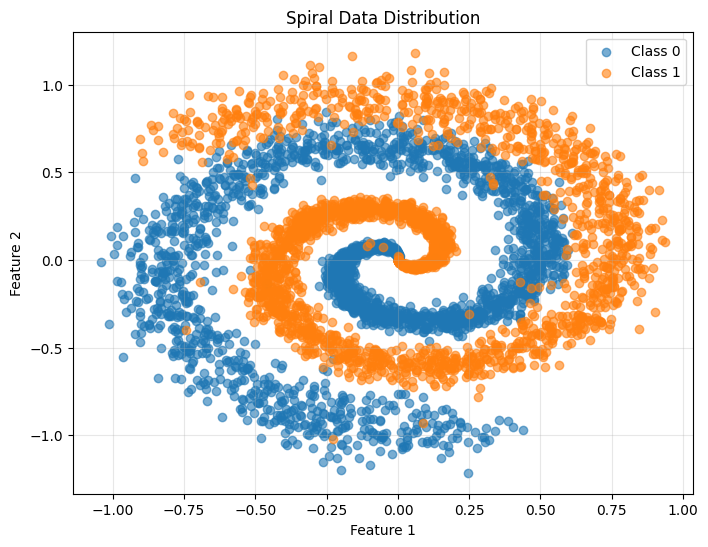

In [25]:
n_train = 5000
k = 2
X,y = utils.generate_spiral_data(m = n_train, noise_level = 0.01,theta_sigma = 0.1, r_sigma = 0.1)
y = (y + 1)//2 # convert {-1,1} to {0,1}
X_train,y_train, x_test,y_test = utils.create_split(X,y, 0.8)

# Create visualization with legend
plt.figure(figsize=(8, 6))
for label in [0, 1]:
    mask = y == label
    plt.scatter(X[mask, 0], X[mask, 1], label=f'Class {label}', alpha=0.6)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Spiral Data Distribution')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


Now, let's see how powerful the neural network is !


In [26]:
model2 = Sequential([
    Linear(2, 128),
    ReLU(),
    Dropout(0.1),
    Linear(128, 128),
    ReLU(),
    Dropout(0.1),
    Linear(128, k)
])
loss = MultiLogisticLoss(k=k)
clf2 = ERMNeuralNetClassifier(model2, loss)
clf2.fit(X_train, y_train, eta=0.01, n_epochs=1000,
        verbose=True, verbose_epoch_interval=100)

y_train_pred = clf2.predict(X_train)
train_err = utils.empirical_err(y_train, y_train_pred)
print(f'train_err: {train_err:5f}')

y_test_pred = clf2.predict(x_test)
test_err = utils.empirical_err(y_test, y_test_pred)
print(f'test_err: {test_err:5f}')



--- Epoch: 0, train_obj: 0.6700698003069753
--- Epoch: 100, train_obj: 0.3933840166425072
--- Epoch: 200, train_obj: 0.1676237771486338
--- Epoch: 300, train_obj: 0.12397674498094854
--- Epoch: 400, train_obj: 0.11468470685389107
--- Epoch: 500, train_obj: 0.10021269765233821
--- Epoch: 600, train_obj: 0.09217148052334445
--- Epoch: 700, train_obj: 0.08788769396134509
--- Epoch: 800, train_obj: 0.08900370506999553
--- Epoch: 900, train_obj: 0.08174217762361312
train_err: 0.018500
test_err: 0.023000


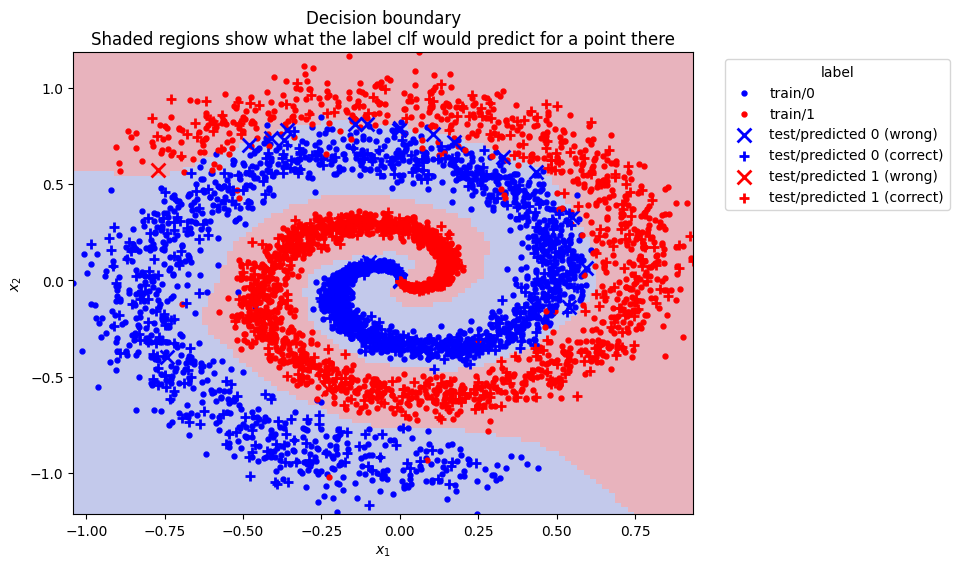

In [28]:
utils.plot_decision_boundary(clf2, X_train, y_train, x_test, y_test,labels=[0,1])


#it is! loll. At first I didn't reset. I got the worest decision boundary ever but the bug is fixed and it is beautiful.


### Fashion MNIST

[Fashion MNIST](https://github.com/zalandoresearch/fashion-mnist): 10 classes, 28×28 grayscale. Data loaded from `.npy`; predict labels for test set.



In [29]:
!mkdir data
!gdown 1oV0HAf_y2fhYb6K6rO5rd1xNNHS6BfZ8  -O data/fmnist_train.npy --quiet
!gdown 1-_XoqNax8_zqoDPV8s3SJv935EPc3jrl  -O data/fmnist_test.npy --quiet


In [30]:
train_data = np.load('data/fmnist_train.npy',allow_pickle=True).item()
test_data = np.load('data/fmnist_test.npy',allow_pickle=True).item()


Examples of Fashion MNIST


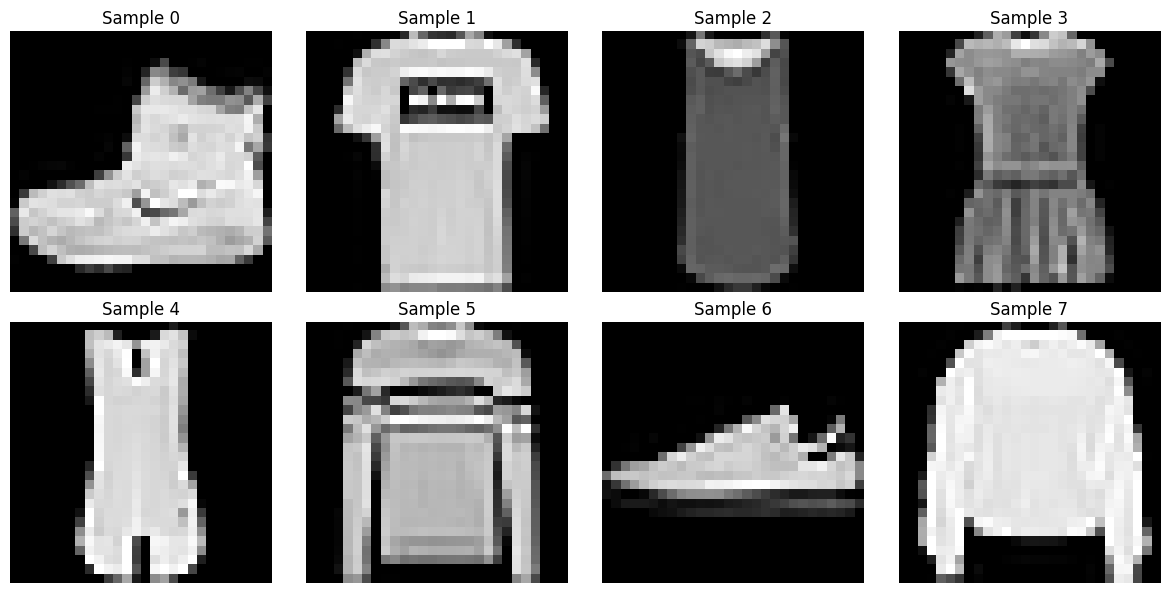

In [31]:
samples = train_data['data'][0:8]
fig, axes = plt.subplots(2, 4, figsize=(12, 6))
for i, ax in enumerate(axes.flat):
    ax.imshow(samples[i], cmap='gray')
    ax.set_title(f'Sample {i}')
    ax.axis('off')
plt.tight_layout()
plt.show()


#### Data Processsing

We first normalize the dataset by dividing all pixel values by 255.
This serves as a simple baseline — there are many ways to achieve better performance, such as designing more effective feature mappings or applying advanced preprocessing techniques to the input data.


In [32]:
xTr, yTr = train_data['data'], train_data['labels']
xTe = test_data['data']
print("Original shape of xTr, yTr, xTe:", xTr.shape, yTr.shape, xTe.shape)
### Let's first play with a subset of the data
n_train = 20000

xTr = xTr[:n_train]
yTr = yTr[:n_train]
### Preprocessing
xTr = xTr.reshape((xTr.shape[0], -1))
xTe = xTe.reshape((xTe.shape[0], -1))
# We first normalize the pixel values to be between 0 and 1
xTr = xTr / 255.
xTe = xTe / 255.

xTr_train, yTr_train, xTr_val, yTr_val = utils.create_split(xTr, yTr, 0.8)
xTr_train = np.array(xTr_train)
yTr_train = np.array(yTr_train)
xTr_val = np.array(xTr_val)
yTr_val = np.array(yTr_val)


Original shape of xTr, yTr, xTe: (60000, 28, 28) (60000,) (10000, 28, 28)


### Optimize Dropout Rate


Let's first look at the effect of regularization.
Note that Neural Networks are powerful for representing functions, but can overfit.
Dropout reduces overfitting; compare with/without.


Training without dropout...
  Run 1/2...
  Run 2/2...
Final - Train Error: 0.0000 ± 0.0000, Val Error: 0.1211 ± 0.0006

Training with dropout rate: 0.3...
  Run 1/2...
  Run 2/2...
Final - Train Error: 0.0000 ± 0.0000, Val Error: 0.1209 ± 0.0011



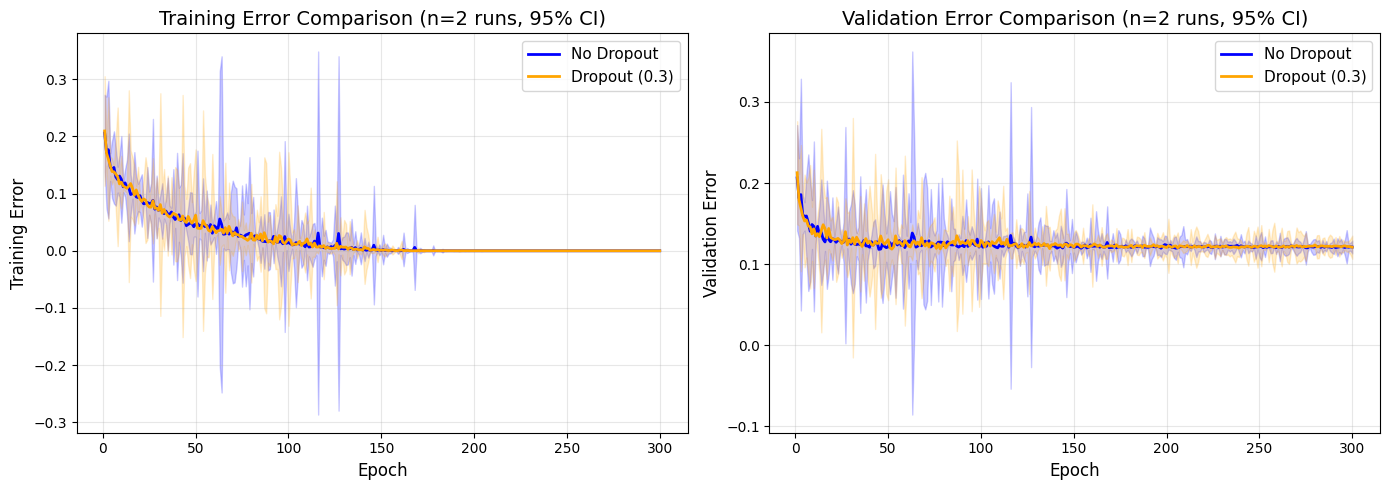

In [35]:
# Train without dropout
print("Training without dropout...")

# Multiple runs for confidence intervals
n_runs = 2 ### <--- you can change the number of runs
train_errs_no_dropout_all = []
val_errs_no_dropout_all = []

for run in range(n_runs):
    print(f"  Run {run+1}/{n_runs}...")
    net_parameter_no_dropout = [
        Linear(xTr_train.shape[1], 128),
        ReLU(),
        Linear(128, 10)
    ]

    model_no_dropout = Sequential(net_parameter_no_dropout)
    loss_no_dropout = MultiLogisticLoss(k=10)
    clf_no_dropout = ERMNeuralNetClassifier(model_no_dropout, loss_no_dropout)

    batch_size = 64
    eta = 0.1
    n_epochs = 300

    # Define error functions for logging
    def val_err_no_dropout(params):
        clf_no_dropout.params = params
        yTr_val_pred = clf_no_dropout.predict(xTr_val)
        return np.mean(yTr_val != yTr_val_pred)

    def train_err_no_dropout(params):
        clf_no_dropout.params = params
        yTr_train_pred = clf_no_dropout.predict(xTr_train)
        return np.mean(yTr_train != yTr_train_pred)

    # Setup SGD with loggers
    sgd_kwargs_no_dropout = {
      'batch_size': batch_size,
      'n_epochs': n_epochs,
      'eta': eta,
      'verbose': False,
      'verbose_epoch_interval': 1,
      'loggers': [
          utils.SGDLogger('train_err', train_err_no_dropout, can_display=True, per_epoch=True),
          utils.SGDLogger('val_err', val_err_no_dropout, can_display=True, per_epoch=True)
      ]
  }

    # Train with loggers
    clf_no_dropout.fit(xTr_train, yTr_train, **sgd_kwargs_no_dropout)

    # Get logged errors
    val_errs = np.array([logger.log for logger in clf_no_dropout.sgd_loggers if logger.name == 'val_err']).flatten()
    train_errs = np.array([logger.log for logger in clf_no_dropout.sgd_loggers if logger.name == 'train_err']).flatten()

    train_errs_no_dropout_all.append(train_errs)
    val_errs_no_dropout_all.append(val_errs)

train_errs_no_dropout_all = np.array(train_errs_no_dropout_all)
val_errs_no_dropout_all = np.array(val_errs_no_dropout_all)

print(f"Final - Train Error: {train_errs_no_dropout_all[:, -1].mean():.4f} ± {train_errs_no_dropout_all[:, -1].std():.4f}, Val Error: {val_errs_no_dropout_all[:, -1].mean():.4f} ± {val_errs_no_dropout_all[:, -1].std():.4f}\n")

# Train with dropout
dropout_rate = 0.3
print(f"Training with dropout rate: {dropout_rate}...")

train_errs_dropout_all = []
val_errs_dropout_all = []

for run in range(n_runs):
    print(f"  Run {run+1}/{n_runs}...")
    net_parameter_dropout = [
        Linear(xTr_train.shape[1], 128),
        ReLU(),
        Dropout(dropout_rate),
        Linear(128, 10)
    ]
    model_dropout = Sequential(net_parameter_dropout)
    loss_dropout = MultiLogisticLoss(k=10)
    clf_dropout = ERMNeuralNetClassifier(model_dropout, loss_dropout)

    # Define error functions for logging
    def val_err_dropout(params):
        clf_dropout.params = params
        yTr_val_pred = clf_dropout.predict(xTr_val)
        return np.mean(yTr_val != yTr_val_pred)

    def train_err_dropout(params):
        clf_dropout.params = params
        yTr_train_pred = clf_dropout.predict(xTr_train)
        return np.mean(yTr_train != yTr_train_pred)

    # Setup SGD with loggers
    sgd_kwargs_dropout = {
      'batch_size': batch_size,
      'n_epochs': n_epochs,
      'eta': eta,
      'verbose': False,
      'verbose_epoch_interval': 1,
      'loggers': [
          utils.SGDLogger('train_err', train_err_dropout, can_display=True, per_epoch=True),
          utils.SGDLogger('val_err', val_err_dropout, can_display=True, per_epoch=True)
      ]
    }

    # Train with loggers
    clf_dropout.fit(xTr_train, yTr_train, **sgd_kwargs_dropout)

    # Get logged errors
    val_errs = np.array([logger.log for logger in clf_dropout.sgd_loggers if logger.name == 'val_err']).flatten()
    train_errs = np.array([logger.log for logger in clf_dropout.sgd_loggers if logger.name == 'train_err']).flatten()

    train_errs_dropout_all.append(train_errs)
    val_errs_dropout_all.append(val_errs)

train_errs_dropout_all = np.array(train_errs_dropout_all)
val_errs_dropout_all = np.array(val_errs_dropout_all)

print(f"Final - Train Error: {train_errs_dropout_all[:, -1].mean():.4f} ± {train_errs_dropout_all[:, -1].std():.4f}, Val Error: {val_errs_dropout_all[:, -1].mean():.4f} ± {val_errs_dropout_all[:, -1].std():.4f}\n")


# <--- Following code is for visualization, you can ignore it ;)
# Compute mean and confidence intervals

train_mean_no_dropout = train_errs_no_dropout_all.mean(axis=0)
train_ci_no_dropout = utils.t_based_ci(train_errs_no_dropout_all, axis = 0)
val_mean_no_dropout = val_errs_no_dropout_all.mean(axis=0)
val_ci_no_dropout = utils.t_based_ci(val_errs_no_dropout_all, axis = 0)

train_mean_dropout = train_errs_dropout_all.mean(axis=0)
train_ci_dropout = utils.t_based_ci(train_errs_dropout_all, axis = 0)
val_mean_dropout = val_errs_dropout_all.mean(axis=0)
val_ci_dropout = utils.t_based_ci(val_errs_dropout_all, axis = 0)

# Visualize comparison with confidence intervals
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

epochs = range(1, n_epochs+1)

# Plot training errors
ax1.plot(epochs, train_mean_no_dropout, label='No Dropout', linewidth=2, color='blue')
ax1.fill_between(epochs, train_mean_no_dropout - train_ci_no_dropout,
                  train_mean_no_dropout + train_ci_no_dropout, alpha=0.2, color='blue')

ax1.plot(epochs, train_mean_dropout, label=f'Dropout ({dropout_rate})', linewidth=2, color='orange')
ax1.fill_between(epochs, train_mean_dropout - train_ci_dropout,
                  train_mean_dropout + train_ci_dropout, alpha=0.2, color='orange')

ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Training Error', fontsize=12)
ax1.set_title(f'Training Error Comparison (n={n_runs} runs, 95% CI)', fontsize=14)
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)

# Plot validation errors
ax2.plot(epochs, val_mean_no_dropout, label='No Dropout', linewidth=2, color='blue')
ax2.fill_between(epochs, val_mean_no_dropout - val_ci_no_dropout,
                  val_mean_no_dropout + val_ci_no_dropout, alpha=0.2, color='blue')

ax2.plot(epochs, val_mean_dropout, label=f'Dropout ({dropout_rate})', linewidth=2, color='orange')
ax2.fill_between(epochs, val_mean_dropout - val_ci_dropout,
                  val_mean_dropout + val_ci_dropout, alpha=0.2, color='orange')

ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Validation Error', fontsize=12)
ax2.set_title(f'Validation Error Comparison (n={n_runs} runs, 95% CI)', fontsize=14)
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


Next, let's find the optimal dropout rate. Note that too high a dropout rate can negatively impact the model's representational capacity.


Testing dropout rate: 0.0
  Train Error: 0.0257, Val Error: 0.1320
Testing dropout rate: 0.1
  Train Error: 0.0231, Val Error: 0.1227
Testing dropout rate: 0.2
  Train Error: 0.0203, Val Error: 0.1207
Testing dropout rate: 0.3
  Train Error: 0.0325, Val Error: 0.1158
Testing dropout rate: 0.4
  Train Error: 0.0461, Val Error: 0.1172
Testing dropout rate: 0.5
  Train Error: 0.0493, Val Error: 0.1155

Best dropout rate: 0.5 with validation error: 0.1155


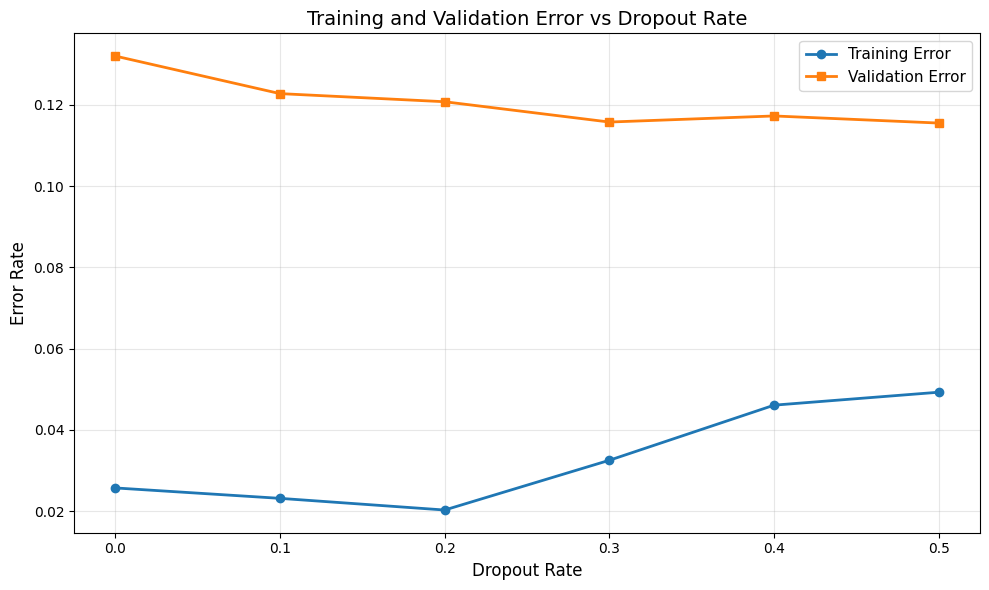

In [36]:
dropout_rates = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]
batch_size = 64
eta = 0.1
n_epochs = 100 # <--- you can change the number of epochs

# Store results for each dropout rate
train_errors = []
val_errors = []

for dropout_rate in dropout_rates:
    print(f"Testing dropout rate: {dropout_rate}")

    # Create model with current dropout rate
    net_parameter = [
        Linear(xTr_train.shape[1], 128),
        ReLU(),
        Dropout(dropout_rate),
        Linear(128, 10)
    ]
    model = Sequential(net_parameter)
    loss = MultiLogisticLoss(k=10)
    clf = ERMNeuralNetClassifier(model, loss)

    # Train the model
    clf.fit(xTr_train, yTr_train, eta=eta, n_epochs=n_epochs, batch_size=batch_size,
            verbose=False, verbose_epoch_interval=1)

    # Compute training error
    train_pred = clf.predict(xTr_train)
    train_err = np.mean(yTr_train != train_pred)
    train_errors.append(train_err)

    # Compute validation error
    val_pred = clf.predict(xTr_val)
    val_err = np.mean(yTr_val != val_pred)
    val_errors.append(val_err)

    print(f"  Train Error: {train_err:.4f}, Val Error: {val_err:.4f}")

# Find best dropout rate
best_dropout_idx = np.argmin(val_errors)
best_dropout_rate = dropout_rates[best_dropout_idx]
print(f"\nBest dropout rate: {best_dropout_rate} with validation error: {val_errors[best_dropout_idx]:.4f}")

# Visualize results
plt.figure(figsize=(10, 6))
plt.plot(dropout_rates, train_errors, marker='o', label='Training Error', linewidth=2)
plt.plot(dropout_rates, val_errors, marker='s', label='Validation Error', linewidth=2)
plt.xlabel('Dropout Rate', fontsize=12)
plt.ylabel('Error Rate', fontsize=12)
plt.title('Training and Validation Error vs Dropout Rate', fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()



### Optimize Learning Rate For Different Batch Sizes


With larger batch size we can use a larger learning rate; we use pre-tuned learning rates per batch size.

Here we will try this experiment again with more powerful Neural Network and more challenging task.

**Remember that this experiment may take a while !**


In [ ]:
batch_sizes = [64, 256, 512, 1024, 2048]
etas = np.logspace(-3, 0, 15)

best_etas = []  # List to store best eta for each batch size
val_errs_per_batch = []  # List to store validation errors for each batch size
bz_to_eta = {}
n_epochs=100
for batch_size in batch_sizes:
    print(f"\nTesting batch size: {batch_size}")
    batch_results = {}

    for eta in etas:
        net_parameter = [
                Linear(xTr_train.shape[1], 128),
                ReLU(),
                Dropout(0.1),
                Linear(128, 10)
            ]
        model = Sequential(net_parameter)
        loss = MultiLogisticLoss(k=10)
        clf = ERMNeuralNetClassifier(model, loss)
        clf.fit(xTr_train, yTr_train, eta=eta, n_epochs=n_epochs, batch_size=batch_size,
        verbose=False, verbose_epoch_interval=1)
        # Compute validation error
        val_pred = clf.predict(xTr_val)
        val_err = np.mean(yTr_val != val_pred)

        batch_results[eta] = val_err

    # Find best eta for this batch size
    best_eta = min(batch_results, key=batch_results.get)
    best_val_err = batch_results[best_eta]

    best_etas.append(best_eta)
    bz_to_eta[batch_size] = best_eta
    val_errs_per_batch.append(list(batch_results.values()))

    print(f"Batch size = {batch_size}, Best learning rate = {best_eta:.6f} with validation error = {best_val_err:.4f}")

# Plot validation errors vs learning rates for each batch size
plt.figure(figsize=(10, 6))
for batch_size, val_err in zip(batch_sizes, val_errs_per_batch):
    plt.plot(etas, val_err, marker='o', label=f'batch_size={batch_size}')
plt.xscale('log')
plt.xlabel('Learning Rate (eta)', fontsize=12)
plt.ylabel('Validation Error', fontsize=12)
plt.legend(fontsize=10)
plt.title('Validation Error vs Learning Rate for Different Batch Sizes', fontsize=14)
plt.grid(True, which="both", ls="-", alpha=0.3)
plt.tight_layout()
plt.show()



Testing batch size: 64
Batch size = 64, Best learning rate = 0.051795 with validation error = 0.1192

Testing batch size: 256


### Batch size and Parallel & Serial Time


We reuse the tuned learning rate (via **bz_to_eta**) and explore how batch size affects training and test error.

Code below computes **serial time** and **parallel time**.


In [ ]:
batch_sizes = [64, 256, 512, 1024, 2048]
dropout_rate = 0.1
n_runs = 5 # <--- you can change the number of runs, But more runs will take more time!!!!!!

# Dictionary to store training results for each batch size
training_results = {}

for batch_size in batch_sizes:
    print(f"\nTraining with batch_size = {batch_size}")
    print("=" * 60)

    # Get the optimal learning rate for this batch size
    eta = bz_to_eta[batch_size]
    print(f"Using optimal learning rate: {eta:.6f}")

    # Initialize storage for this batch size
    training_results[batch_size] = {
        'test_errs': [],
        'train_errs': [],
        'serial_time': [],
        'parallel_time': []
    }

    # Run multiple times for statistical significance
    for run in range(n_runs):
        print(f"  Run {run + 1}/{n_runs}...", end=" ")

        # Create fresh model for each run
        net_parameter = [
            Linear(xTr_train.shape[1], 128),
            ReLU(),
            Dropout(dropout_rate),
            Linear(128, 128),
            ReLU(),
            Dropout(dropout_rate),
            Linear(128, 10)
        ]
        model = Sequential(net_parameter)
        loss = MultiLogisticLoss(k=10)
        clf = ERMNeuralNetClassifier(model, loss)

        # Define error functions for logging
        def val_err(params):
            clf.params = params
            yTr_val_pred = clf.predict(xTr_val)
            return np.mean(yTr_val != yTr_val_pred)

        def train_err(params):
            clf.params = params
            yTr_train_pred = clf.predict(xTr_train)
            return np.mean(yTr_train != yTr_train_pred)

        # Setup SGD with loggers
        sgd_kwargs = {
            'batch_size': batch_size,
            'n_epochs': 100, ## <--- you can change the number of epochs, more epochs will take more time!!!!!!
            'eta': eta,
            'verbose': False,
            'verbose_epoch_interval': 1,
            'loggers': [
                utils.SGDLogger('train_err', train_err, can_display=True, per_epoch=True),
                utils.SGDLogger('val_err', val_err, can_display=True, per_epoch=True)
            ]
        }

        # Train the model
        clf.fit(xTr_train, yTr_train, **sgd_kwargs)

        # Extract logged errors
        val_errs = np.array([logger.log for logger in clf.sgd_loggers if logger.name == 'val_err']).flatten()
        train_errs = np.array([logger.log for logger in clf.sgd_loggers if logger.name == 'train_err']).flatten()

        # Compute serial and parallel time
        n_samples = xTr_train.shape[0]
        n_epochs = len(val_errs)
        epochs = np.arange(1, n_epochs + 1)

        # Serial time: total number of samples processed
        serial_time = n_samples * epochs


        # Parallel time: number of batches processed
        parallel_time = np.ceil(n_samples / batch_size) * epochs

        # Store results
        training_results[batch_size]['test_errs'].append(val_errs)
        training_results[batch_size]['train_errs'].append(train_errs)
        training_results[batch_size]['serial_time'].append(serial_time)
        training_results[batch_size]['parallel_time'].append(parallel_time)

        print(f"Final val_err: {val_errs[-1]:.4f}, train_err: {train_errs[-1]:.4f}")

print("\n" + "=" * 60)
print("Training complete for all batch sizes!")


**Batch size vs performance:** (1) Serial time budget → test error (2) Parallel time budget → test error (3) Target test error → serial time (4) Target test error → parallel time.


In [ ]:
def compute_fixed_time(training_results, batch_sizes, fixed_serial_times, fixed_parallel_times,compute_ci=True,err_type='test_errs'):
    serial_mean, serial_ci = {}, {}
    parallel_mean, parallel_ci = {}, {}

    # ---------- serial ----------
    for T_s in fixed_serial_times:
        serial_mean[T_s], serial_ci[T_s] = [], []
        for b in batch_sizes:
            errs = []
            runs = training_results[b][err_type]
            n_runs = len(runs)

            for m in range(n_runs):
                err = training_results[b][err_type][m]
                serial_time = training_results[b]['serial_time'][m]
                mask = serial_time <= T_s
                if np.any(mask):
                    errs.append(np.min(err[mask]))

            if len(errs) > 0:
                serial_mean[T_s].append(np.mean(errs))
                serial_ci[T_s].append(utils.t_based_ci(errs)) if compute_ci else serial_ci[T_s].append(None)
            else:
                serial_mean[T_s].append(np.nan)
                serial_ci[T_s].append(0)

    # ---------- parallel ----------
    for T_p in fixed_parallel_times:
        parallel_mean[T_p], parallel_ci[T_p] = [], []
        for b in batch_sizes:
            errs = []
            runs = training_results[b][err_type]
            n_runs = len(runs)

            for m in range(n_runs):
                err = training_results[b][err_type][m]
                parallel_time = training_results[b]['parallel_time'][m]
                mask = parallel_time <= T_p
                if np.any(mask):
                    errs.append(np.min(err[mask]))

            if len(errs) > 0:
                parallel_mean[T_p].append(np.mean(errs))
                parallel_ci[T_p].append(utils.t_based_ci(errs)) if compute_ci else parallel_ci[T_p].append(None)
            else:
                parallel_mean[T_p].append(np.nan)
                parallel_ci[T_p].append(0)

    return serial_mean, serial_ci, parallel_mean, parallel_ci


def plot_fixed_time_results(serial_mean, serial_ci, parallel_mean, parallel_ci,
                            batch_sizes, fixed_serial_times, fixed_parallel_times,
                            use_logscale=False, palette="Set2", show_confidence=True,err_type='test_errs'):
    n_serial = len(fixed_serial_times)
    n_parallel = len(fixed_parallel_times)

    colors_serial = sns.color_palette(palette, n_colors=n_serial)
    colors_parallel = sns.color_palette(palette, n_colors=n_parallel)

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    # === Left: serial ===
    ax = axes[0]
    width = 0.8 / n_serial
    x = np.arange(len(batch_sizes))

    for i, T_s in enumerate(fixed_serial_times):
        means = np.array(serial_mean[T_s])
        cis = np.array(serial_ci[T_s])

        offset = (i - n_serial/2 + 0.5) * width

        if show_confidence and np.any(cis):
            cis = np.nan_to_num(cis, nan=0.0)
            ax.bar(x + offset, means, width,
                   yerr=cis,
                   capsize=3,
                   color=colors_serial[i],
                   label=f"$t_s={T_s:.1e}$",
                   edgecolor='black',
                   linewidth=0.5,
                   alpha=0.8)
        else:
            ax.bar(x + offset, means, width,
                   color=colors_serial[i],
                   label=f"$t_s={T_s:.1e}$",
                   edgecolor='black',
                   linewidth=0.5,
                   alpha=0.8)

    ax.set_xlabel("Batch size", fontsize=11)
    ax.set_ylabel("Test error", fontsize=11) if err_type == 'test_errs' else ax.set_ylabel("Training error", fontsize=11)
    ax.set_title("Best test error at fixed serial time", fontsize=12) if err_type == 'test_errs' else ax.set_title("Best training error at fixed serial time", fontsize=12)
    ax.set_xticks(x)
    ax.set_xticklabels(batch_sizes)
    ax.legend(title="Fixed serial time", fontsize=9)
    ax.grid(True, linestyle="--", alpha=0.4, axis='y')
    if use_logscale:
        ax.set_yscale("log")

    # === Right: parallel ===
    ax = axes[1]
    width = 0.8 / n_parallel
    x = np.arange(len(batch_sizes))

    for i, T_p in enumerate(fixed_parallel_times):
        means = np.array(parallel_mean[T_p])
        cis = np.array(parallel_ci[T_p])

        offset = (i - n_parallel/2 + 0.5) * width

        if show_confidence and np.any(cis):
            cis = np.nan_to_num(cis, nan=0.0)
            ax.bar(x + offset, means, width,
                   yerr=cis,
                   capsize=3,
                   color=colors_parallel[i],
                   label=f"$t_p={T_p:.1e}$",
                   edgecolor='black',
                   linewidth=0.5,
                   alpha=0.8)
        else:
            ax.bar(x + offset, means, width,
                   color=colors_parallel[i],
                   label=f"$t_p={T_p:.1e}$",
                   edgecolor='black',
                   linewidth=0.5,
                   alpha=0.8)

    ax.set_xlabel("Batch size", fontsize=11)
    ax.set_ylabel("Test error", fontsize=11) if err_type == 'test_errs' else ax.set_ylabel("Training error", fontsize=11)
    ax.set_title("Best Test error at fixed parallel time", fontsize=12) if err_type == 'test_errs' else ax.set_title("Best training error at fixed parallel time", fontsize=12)
    ax.set_xticks(x)
    ax.set_xticklabels(batch_sizes)
    ax.legend(title="Fixed parallel time", fontsize=9)
    ax.grid(True, linestyle="--", alpha=0.4, axis='y')
    if use_logscale:
        ax.set_yscale("log")

    plt.tight_layout()
    plt.show()

def compute_time_to_target(training_results, batch_sizes, target_errs,compute_ci=True,err_type='test_errs'):
    serial_mean, serial_ci = {}, {}
    parallel_mean, parallel_ci = {}, {}

    for e_target in target_errs:
        serial_mean[e_target], serial_ci[e_target] = [], []
        parallel_mean[e_target], parallel_ci[e_target] = [], []

        for b in batch_sizes:
            serial_times, parallel_times = [], []
            runs = training_results[b][err_type]
            n_runs = len(runs) if isinstance(runs, list) else 1

            for m in range(n_runs):
                err = training_results[b][err_type][m]
                serial_time = training_results[b]['serial_time'][m]
                parallel_time = training_results[b]['parallel_time'][m]

                idx = np.where(err <= e_target)[0]
                if len(idx) > 0:
                    serial_times.append(serial_time[idx[0]])
                    parallel_times.append(parallel_time[idx[0]])

            # mean ± t-based CI or single value
            if len(serial_times) > 0:
                serial_mean[e_target].append(np.mean(serial_times))
                serial_ci[e_target].append(utils.t_based_ci(serial_times)) if compute_ci else serial_ci[e_target].append(None)
            else:
                serial_mean[e_target].append(np.nan)
                serial_ci[e_target].append(0)

            if len(parallel_times) > 0:
                parallel_mean[e_target].append(np.mean(parallel_times))
                parallel_ci[e_target].append(utils.t_based_ci(parallel_times)) if compute_ci else parallel_ci[e_target].append(None)
            else:
                parallel_mean[e_target].append(np.nan)
                parallel_ci[e_target].append(0)

    return serial_mean, serial_ci, parallel_mean, parallel_ci


def plot_time_to_target(serial_mean, serial_ci, parallel_mean, parallel_ci,
                        batch_sizes, target_errs, use_logscale=True,
                        show_confidence=True,
                        err_type='test_errs'):
    n_targets = len(target_errs)
    width = 0.8 / n_targets
    x_base = np.arange(len(batch_sizes))

    colors = sns.color_palette("Set2", n_colors=n_targets)

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    # === helper for consistent bar plotting ===
    def plot_panel(ax, mean_dict, ci_dict, ylabel, title):
        for i, e_target in enumerate(target_errs):
            means = mean_dict[e_target]
            cis = ci_dict[e_target] if show_confidence else [0] * len(means)

            if show_confidence and np.any(cis):
                cis = np.nan_to_num(cis, nan=0.0)
                ax.bar(
                    x_base + i * width,
                    means,
                    yerr=cis,
                    capsize=3,
                    width=width,
                    color=colors[i],
                    edgecolor='black',
                    linewidth=0.5,
                    alpha=0.8,
                    label=f"$e_{{target}}={e_target:.2f}$"
                )
            else:
                ax.bar(
                    x_base + i * width,
                    means,
                    width=width,
                    color=colors[i],
                    edgecolor='black',
                    linewidth=0.5,
                    alpha=0.8,
                    label=f"$e_{{target}}={e_target:.2f}$"
                )

        ax.set_xticks(x_base + width * (n_targets - 1) / 2)
        ax.set_xticklabels(batch_sizes)
        ax.set_xlabel("Batch size", fontsize=11)
        ax.set_ylabel(ylabel, fontsize=11)
        ax.set_title(title, fontsize=12)
        ax.grid(axis="y", linestyle="--", alpha=0.4)
        ax.legend(title="Target error", fontsize=9)
        if use_logscale:
            ax.set_yscale('log')

    plot_panel(axes[0], serial_mean, serial_ci, "Serial time (s)", "Serial time to reach target error")
    plot_panel(axes[1], parallel_mean, parallel_ci, "Parallel time (s)", "Parallel time to reach target error")

    plt.tight_layout()
    plt.show()


In [ ]:
fixed_serial_times = [16000, 32000, 48000, 64000] # you are encouraged to try different serial times and parallel times to see the trend
fixed_parallel_times = [400, 600, 800, 1000]

serial_mean, serial_ci, parallel_mean, parallel_ci = compute_fixed_time(training_results, batch_sizes,
                                                                        fixed_serial_times, fixed_parallel_times,
                                                                        compute_ci=True)
plot_fixed_time_results(serial_mean, serial_ci,
                        parallel_mean, parallel_ci,
                        batch_sizes,
                        fixed_serial_times, fixed_parallel_times,
                        show_confidence=True)


Feel free to change the target errors ~


In [ ]:

target_errs = [0.3, 0.2, 0.18]
serial_mean, serial_ci, parallel_mean, parallel_ci = compute_time_to_target(
    training_results,
    batch_sizes,
    target_errs,
    compute_ci=False
)
plot_time_to_target(serial_mean, serial_ci, parallel_mean, parallel_ci, batch_sizes, target_errs,show_confidence=False)


<span style="color: red">
**Notes**

Larger batch + tuned LR: compare serial vs parallel time and test error. With GPUs, parallel vs serial gap is much larger.

<h4 style="font-weight: bold">---------------------</h4>
</span>


### Cross-validation and final model


Example setup: deeper/wider nets, different optimizers, and regularization (e.g. dropout) can improve results.


In [ ]:
# Hyperparameter search using validation data
dropout_rates = [0.0, 0.1,]
learning_rates = [0.01,]
batch_sizes = [256, 512]

best_val_err = float('inf')
best_params = {}
best_model = None

print("Starting hyperparameter search...")
print("=" * 80)

for dropout_rate in dropout_rates:
    for eta in learning_rates:
        for batch_size in batch_sizes:
            print(f"\nTesting: dropout={dropout_rate}, eta={eta}, batch_size={batch_size}")

            # Create model with current hyperparameters
            model = Sequential([
                Linear(xTr_train.shape[1], 128),
                ReLU(),
                Dropout(dropout_rate),
                Linear(128, 10)
            ])
            loss = MultiLogisticLoss(k=10)
            clf = ERMNeuralNetClassifier(model, loss)

            sgd_kwargs = {
                'batch_size': batch_size,
                'n_epochs': 100,
                'eta': eta,
                'verbose': False,  # Disable printing for cleaner output during search
                'verbose_epoch_interval': 1,
            }

            # Train the model
            clf.fit(xTr_train, yTr_train, **sgd_kwargs)

            # Evaluate on validation set
            yTr_val_pred = clf.predict(xTr_val)
            val_err = utils.empirical_err(yTr_val, yTr_val_pred)

            print(f"  Validation error: {val_err:.5f}")

            # Update best model if this one is better
            if val_err < best_val_err:
                best_val_err = val_err
                best_params = {
                    'dropout_rate': dropout_rate,
                    'eta': eta,
                    'batch_size': batch_size
                }
                best_model = clf
                print(f"  *** New best model found! ***")

print("\n" + "=" * 80)
print("Hyperparameter search complete!")
print(f"Best parameters: {best_params}")
print(f"Best validation error: {best_val_err:.5f}")
print("=" * 80)

# Train final model with best hyperparameters
print("\nTraining final model with best hyperparameters...")
model = Sequential([
    Linear(xTr_train.shape[1], 128),
    ReLU(),
    Dropout(best_params['dropout_rate']),
    Linear(128, 10)
])
loss = MultiLogisticLoss(k=10)
clf = ERMNeuralNetClassifier(model, loss)

sgd_kwargs = {
    'batch_size': best_params['batch_size'],
    'n_epochs': 100,
    'eta': best_params['eta'],
    'verbose': False,  # Enable printing for final training
    'verbose_epoch_interval': 1,
}

clf.fit(xTr_train, yTr_train, **sgd_kwargs)

yTr_train_pred = clf.predict(xTr_train)
train_err = utils.empirical_err(yTr_train, yTr_train_pred)

yTr_val_pred = clf.predict(xTr_val)
val_err = utils.empirical_err(yTr_val, yTr_val_pred)

print(f'\nFinal Results:')
print(f'train_err: {train_err:.5f}, val_err: {val_err:.5f}')


In [ ]:
xTe_pred = clf.predict(xTe)


In [ ]:


with open('project_baseline_prediction.csv', 'w') as f:
    f.write('id,label\n')
    for i, label in enumerate(xTe_pred, start=0):
        f.write(f"{i},{label}\n")  # Write ID and label


**NN result:**  accuracy **0.94980** 

